## Setup Environment

In [ ]:
# Install specific libraries
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/Project11_FakeNewsDetection

# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('/Users//replace_me')

/content/drive/MyDrive/Project11_FakeNewsDetection


## Load Dataset

In [ ]:
# Load Dataset
true_data = pd.read_csv('a1_True.csv')
fake_data = pd.read_csv('a2_Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = 'True'
fake_data['Target'] = 'Fake'

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index().drop(columns=['index'])

# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,Two-thirds of US Navy Strike Fighter Jets Grou...,21st Century Wire says Defense News said that ...,US_News,"February 12, 2017",Fake
1,Ryan on Orlando shooting: 'We are a nation at ...,WASHINGTON (Reuters) - House of Representative...,politicsNews,"June 12, 2016",True
2,U.S. appeals court removes new voter-intimidat...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"November 6, 2016",True
3,(VIDEO) CAIR LAWSUIT FIGHTS “IGNORANCE”: WOMEN...,"CAIR continues to nudge, nudge, nudge the Amer...",politics,"Aug 17, 2015",Fake
4,Lebanon president seeks diplomatic help on PM ...,BEIRUT (Reuters) - Lebanese President Michel A...,worldnews,"November 9, 2017",True


In [ ]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake']

In [ ]:
data.head()

,title,text,subject,date,Target,label
0,Two-thirds of US Navy Strike Fighter Jets Grou...,21st Century Wire says Defense News said that ...,US_News,"February 12, 2017",Fake,True
1,Ryan on Orlando shooting: 'We are a nation at ...,WASHINGTON (Reuters) - House of Representative...,politicsNews,"June 12, 2016",True,False
2,U.S. appeals court removes new voter-intimidat...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"November 6, 2016",True,False
3,(VIDEO) CAIR LAWSUIT FIGHTS “IGNORANCE”: WOMEN...,"CAIR continues to nudge, nudge, nudge the Amer...",politics,"Aug 17, 2015",Fake,True
4,Lebanon president seeks diplomatic help on PM ...,BEIRUT (Reuters) - Lebanese President Michel A...,worldnews,"November 9, 2017",True,False


([<matplotlib.patches.Wedge at 0x7b2b4c378c40>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

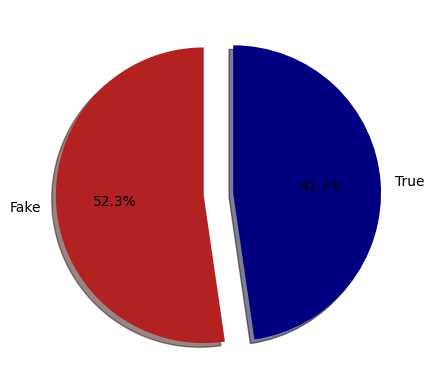

In [ ]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Train-test-split

In [ ]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

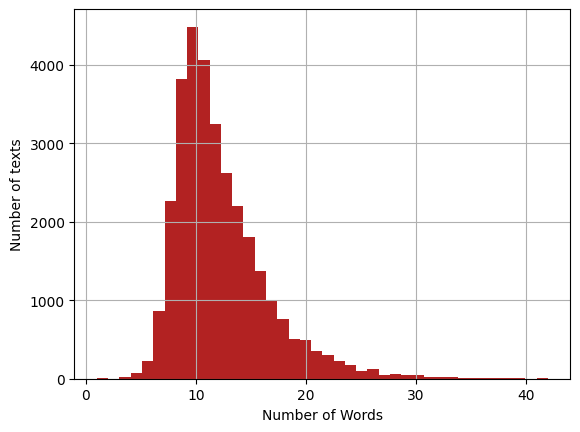

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.",
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

### Freeze Layers

In [ ]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 1

### Define Train & Evaluate Function

In [ ]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels.long())                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(val_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

In [ ]:
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        sent_id, mask, labels = [r.to(device) for r in batch]  # Push the batch to the device (CPU or GPU)
        labels = labels.long()  # Convert labels to Long data type
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss = 0

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        sent_id, mask, labels = [t.to(device) for t in batch]
        labels = labels.long()  # Convert labels to Long data type
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

In [ ]:
import torch
print(torch.cuda.is_available())


False


In [ ]:
device = torch.device('cpu')
model.to(device)


BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [ ]:
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # Move batch to CPU
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels.long())
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


### Model training

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 1
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.561
Validation Loss: 0.492


### Model performance

In [ ]:
# load weights of best model
#path = 'c1_fakenews_weights.pt'
#model.load_state_dict(torch.load(path))

In [ ]:
# load weights of best model
path = 'c1_fakenews_weights.pt'
state_dict = torch.load(path)
for key in list(state_dict.keys()):
    if 'position_ids' in key:
        del state_dict[key]
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

       False       0.84      0.92      0.88      3212
        True       0.92      0.84      0.88      3523

    accuracy                           0.88      6735
   macro avg       0.88      0.88      0.88      6735
weighted avg       0.88      0.88      0.88      6735



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Assuming y_val and y_pred are your true labels and predicted labels, respectively
y_true = y_val  # Ground truth labels from validation set
y_pred = svm_model.predict(X_val_tfidf)  # Predicted labels from SVM model

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate True Positives, False Positives, False Negatives for each class
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# Calculate Precision, Recall, F1-score for each class
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate macro-averaged precision, recall, F1-score
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1_score = np.mean(f1_score)

# Calculate weighted-averaged precision, recall, F1-score
weighted_precision = np.sum(precision * (true_positives + false_positives)) / np.sum(true_positives + false_positives)
weighted_recall = np.sum(recall * (true_positives + false_negatives)) / np.sum(true_positives + false_negatives)
weighted_f1_score = np.sum(f1_score * (true_positives + false_negatives)) / np.sum(true_positives + false_negatives)

# Print results
print("Precision, Recall, F1-score for each class:")
for i in range(len(precision)):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

print("\nMacro-averaged metrics:")
print(f"Macro-averaged Precision: {macro_precision:.3f}")
print(f"Macro-averaged Recall: {macro_recall:.3f}")
print(f"Macro-averaged F1-score: {macro_f1_score:.3f}")

print("\nWeighted-averaged metrics:")
print(f"Weighted-averaged Precision: {weighted_precision:.3fs}")
print(f"Weighted-averaged Recall: {weighted_recall:.3f}")
print(f"Weighted-averaged F1-score: {weighted_f1_score:.3f}")

# Additional metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Precision, Recall, F1-score for each class:
Class 0:
  Precision: 0.961
  Recall: 0.927
  F1-score: 0.944
Class 1:
  Precision: 0.923
  Recall: 0.958
  F1-score: 0.940

Macro-averaged metrics:
Macro-averaged Precision: 0.942
Macro-averaged Recall: 0.943
Macro-averaged F1-score: 0.942

Weighted-averaged metrics:
Weighted-averaged Precision: 0.942
Weighted-averaged Recall: 0.942
Weighted-averaged F1-score: 0.942

Accuracy: 0.942

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3522
           1       0.92      0.96      0.94      3213

    accuracy                           0.94      6735
   macro avg       0.94      0.94      0.94      6735
weighted avg       0.94      0.94      0.94      6735



In [ ]:
import numpy as np

# Convert predictions to numpy array if not already
preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds

# Convert test_y to numpy array if not already
test_y = test_y.cpu().numpy() if isinstance(test_y, torch.Tensor) else test_y

# Calculate True Positives, False Positives, False Negatives for each class
conf_matrix = np.zeros((2, 2), dtype=np.int64)
for true_label, pred_label in zip(test_y, preds):
    conf_matrix[true_label, pred_label] += 1

true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# Calculate Precision, Recall, F1-score for each class
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate macro-averaged precision, recall, F1-score
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1_score = np.mean(f1_score)

# Calculate weighted-averaged precision, recall, F1-score
weighted_precision = np.sum(precision * (true_positives + false_positives)) / np.sum(true_positives + false_positives)
weighted_recall = np.sum(recall * (true_positives + false_negatives)) / np.sum(true_positives + false_negatives)
weighted_f1_score = np.sum(f1_score * (true_positives + false_negatives)) / np.sum(true_positives + false_negatives)

# Print results
print("Precision, Recall, F1-score for each class:")
for i in range(2):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

print("\nMacro-averaged metrics:")
print(f"Macro-averaged Precision: {macro_precision:.3f}")
print(f"Macro-averaged Recall: {macro_recall:.3f}")
print(f"Macro-averaged F1-score: {macro_f1_score:.3f}")

print("\nWeighted-averaged metrics:")
print(f"Weighted-averaged Precision: {weighted_precision:.3f}")
print(f"Weighted-averaged Recall: {weighted_recall:.3f}")
print(f"Weighted-averaged F1-score: {weighted_f1_score:.3f}")


NameError: name 'preds' is not defined

## Fake News Predictions

In [ ]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

In [ ]:
unseen_news_text = [r"President Trump slammed Nancy Pelosi Tuesday, calling her a 'sick woman' with a lot of 'mental problems' after Pelosi said Trump should fear for his life taking hydroxychloroquine because he is 'morbidly obese'. Trump also hit out at a study on hydroxychloroquine, claiming it can have severe side effects leading to death, calling the results a 'Trump enemy statement.'",
                    "I’ve worked with doctors and if you look at the one survey – the only bad survey – they were giving it to people that were in very bad shape. They were very old, almost dead. the President asserted.",
                    "Trump again claimed that many front line healthcare workers are taking hydroxychloroquine. 'A lot of our front line workers take it because it possibly and – I think it does but you know these people are going to have to make up their own mind. Plus, it doesn’t hurt people. It’s been out of the market for 60 or 65 years for malaria, lupus and other things,' he said.",
                    "I think it gives you an additional level of safety, but you can ask many doctors are in favor of it. Many front line workers won’t go there, unless they have the hydroxy. the President continued.",
                    "Yesterday, Senate Minority Leader Chuck Schumer claimed that Trump must have some financial interest in hydroxychloroquine, a claim that has previously been proven false. 'Maybe he has family or friends who own part of the company. It’s not unlike the president. Someone at Mar-A-Lago, calls him on the phone, tells him, ‘Oh, this is a good company,’ and he just talks about it. Maybe he did it to divert attention from all the bad things happening, and maybe he’s just lying.' Schumer told MSNBC’s Morning Joe.",
                    "'This president doesn’t tell the truth. He may be taking this, may not,' Schumer also charged, echoing host Joe Scarborough who proclaimed that 'the president is not taking it, and yet, and yet, he’s telling Americans that they should take it.'"]


# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 1, 1, 0, 0])

In [ ]:
# testing on unseen data
unseen_news_text = [
                    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Elections cancelled in India",                        # True
                   ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 0, 0])

In [ ]:
import os

directory = "C:\\Users\\SOT-4\\Desktop\\vamsi"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the path to save the model
save_path = os.path.join(directory, "dhruval.pth")

# Save the model
torch.save(model, save_path)

In [ ]:
torch.save(model, '/content/dhruval.pth')

In [ ]:
torch.save(model.state_dict(), '/content/dhruval_state_dict.pth')

In [ ]:
loaded_model = torch.load('/content/dhruval.pth')

loaded_model.eval()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [ ]:
# Tokenize and encode sequences in the test set
unseen_news_text = ["Second court rejects Trump bid to stop transgender military recruits"]
MAX_LENGTH = 150
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
    preds = loaded_model(unseen_seq, unseen_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
preds


array([0])

# SVM

In [ ]:
!pip install pandas numpy openpyxl

In [ ]:
pip install xlrd

In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Dataset
true_data = pd.read_csv('/content/drive/MyDrive/Project11_FakeNewsDetection/a1_True.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/Project11_FakeNewsDetection/a2_Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = 'True'
fake_data['Target'] = 'Fake'

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index().drop(columns=['index'])

# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,Native American Tribal Leader Shuts Down Oreg...,It has been almost a week since over 20 armed ...,News,"January 7, 2016",Fake
1,WATCH: Hillary Smacks Trump With His Own Word...,Donald Trump has made a lot of offensive state...,News,"May 27, 2016",Fake
2,Episode #154 – SUNDAY WIRE: ‘The Pro-War Left?...,Episode #154 of SUNDAY WIRE SHOW resumes this...,Middle-east,"September 25, 2016",Fake
3,Second U.S. judge blocks Trump administration ...,SAN FRANCISCO (Reuters) - A second U.S. judge ...,politicsNews,"December 21, 2017",True
4,RECKLESS: CLINTON PRESIDENCY Could Mean U.S. M...,Hillary Clinton always putting a radical ideol...,Government News,"Jul 25, 2016",Fake


In [ ]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake']

In [ ]:
data.head()

,title,text,subject,date,Target,label
0,Native American Tribal Leader Shuts Down Oreg...,It has been almost a week since over 20 armed ...,News,"January 7, 2016",Fake,True
1,WATCH: Hillary Smacks Trump With His Own Word...,Donald Trump has made a lot of offensive state...,News,"May 27, 2016",Fake,True
2,Episode #154 – SUNDAY WIRE: ‘The Pro-War Left?...,Episode #154 of SUNDAY WIRE SHOW resumes this...,Middle-east,"September 25, 2016",Fake,True
3,Second U.S. judge blocks Trump administration ...,SAN FRANCISCO (Reuters) - A second U.S. judge ...,politicsNews,"December 21, 2017",True,False
4,RECKLESS: CLINTON PRESIDENCY Could Mean U.S. M...,Hillary Clinton always putting a radical ideol...,Government News,"Jul 25, 2016",Fake,True


([<matplotlib.patches.Wedge at 0x7b8faf8445b0>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

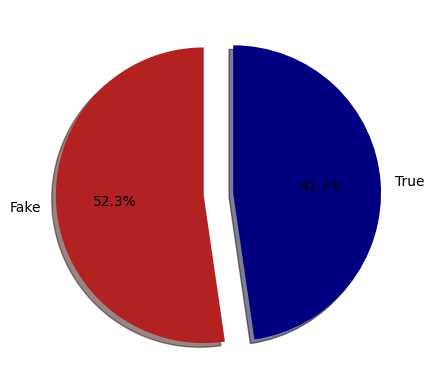

In [ ]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
train_data = pd.DataFrame({'title': train_text, 'label': train_labels})
val_data = pd.DataFrame({'title': val_text, 'label': val_labels})
test_data = pd.DataFrame({'title': test_text, 'label': test_labels})

In [ ]:
# Save the DataFrames to CSV files
train_data.to_csv('/content/drive/MyDrive/Project11_FakeNewsDetection/train.csv', index=False)
val_data.to_csv('/content/drive/MyDrive/Project11_FakeNewsDetection/val.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/Project11_FakeNewsDetection/test.csv', index=False)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(train_data['title'])
X_val_tfidf = vectorizer.transform(val_data['title'])
X_test_tfidf = vectorizer.transform(test_data['title'])

# Train the SVM model
svm_model = SVC()
svm_model.fit(X_train_tfidf, train_data['label'])

# Validate the model
val_predictions = svm_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(val_data['label'], val_predictions)

print(f'Validation Accuracy: {val_accuracy}')

# Test the model
test_predictions = svm_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(test_data['label'], test_predictions)

print(f'Test Accuracy: {test_accuracy}')

Validation Accuracy: 0.9523385300668151
Test Accuracy: 0.9515961395694135


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Assuming val_labels are your true labels from the validation set
y_true = val_labels
y_pred = svm_model.predict(X_val_tfidf)  # Predicted labels from the SVM model

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate True Positives, False Positives, False Negatives for each class
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# Calculate Precision, Recall, F1-score for each class
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Calculate macro-averaged precision, recall, F1-score
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1_score = np.mean(f1_score)

# Calculate weighted-averaged precision, recall, F1-score
support = np.sum(conf_matrix, axis=1)  # Number of true instances for each class
weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
weighted_f1_score = np.sum(f1_score * support) / np.sum(support)

# Print results
print("Precision, Recall, F1-score for each class:")
for i in range(len(precision)):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

print("\nMacro-averaged metrics:")
print(f"Macro-averaged Precision: {macro_precision:.3f}")
print(f"Macro-averaged Recall: {macro_recall:.3f}")
print(f"Macro-averaged F1-score: {macro_f1_score:.3f}")

print("\nWeighted-averaged metrics:")
print(f"Weighted-averaged Precision: {weighted_precision:.3f}")
print(f"Weighted-averaged Recall: {weighted_recall:.3f}")
print(f"Weighted-averaged F1-score: {weighted_f1_score:.3f}")

# Additional metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Precision, Recall, F1-score for each class:
Class 0:
  Precision: 0.945
  Recall: 0.956
  F1-score: 0.950
Class 1:
  Precision: 0.959
  Recall: 0.949
  F1-score: 0.954

Macro-averaged metrics:
Macro-averaged Precision: 0.952
Macro-averaged Recall: 0.952
Macro-averaged F1-score: 0.952

Weighted-averaged metrics:
Weighted-averaged Precision: 0.952
Weighted-averaged Recall: 0.952
Weighted-averaged F1-score: 0.952

Accuracy: 0.952

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.96      0.95      3213
        True       0.96      0.95      0.95      3522

    accuracy                           0.95      6735
   macro avg       0.95      0.95      0.95      6735
weighted avg       0.95      0.95      0.95      6735



In [ ]:
# Example input sentence
input_sentence = "Factbox: Trump U.S. Supreme Court pick could affect pending cases"

# Preprocess and vectorize the input sentence
input_sentence_tfidf = vectorizer.transform([input_sentence])

# Predict using trained SVM model
predicted_label = svm_model.predict(input_sentence_tfidf)

# Print the predicted label
print(f"Input Sentence: {input_sentence}")
print(f"Predicted Label: {predicted_label[0]}")

Input Sentence: Factbox: Trump U.S. Supreme Court pick could affect pending cases
Predicted Label: False


In [ ]:
# List of input sentences
input_sentences = [
    "Jones certified U.S. Senate winner despite Moore challenge"
]

# Preprocess and vectorize the input sentences
input_sentences_tfidf = vectorizer.transform(input_sentences)

# Predict using trained SVM model
predicted_labels = svm_model.predict(input_sentences_tfidf)

# Print the predicted labels for each input sentence
for sentence, label in zip(input_sentences, predicted_labels):
    # Print 1 for True and 0 for False
    print(f"Input Sentence: {sentence}")
    print(f"Predicted Label: {1 if label else 0}")
    print()  # Print a blank line for better readability


Input Sentence: Jones certified U.S. Senate winner despite Moore challenge
Predicted Label: 0



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import joblib

# Define the pipeline with TF-IDF vectorizer and SVM classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svm', SVC())
])

# Fit the pipeline with your training data
pipeline.fit(train_data['title'], train_data['label'])

# Save the pipeline to a file
model_filename = '/content/drive/MyDrive/Project11_FakeNewsDetection/svm_model_pipeline.pkl'
joblib.dump(pipeline, model_filename)

print(f"Pipeline saved to {model_filename}")


Pipeline saved to /content/drive/MyDrive/Project11_FakeNewsDetection/svm_model_pipeline.pkl


In [ ]:
# Load the saved pipeline using pickle
with open(pipeline_file_path, 'rb') as f:
    loaded_pipeline = pickle.load(f)

# Example test data
X_test = test_data['title'].astype(str)  # Assuming you have test_data defined similarly

# Predict using the loaded pipeline
y_pred = loaded_pipeline.predict(X_test)

# Print or use y_pred as needed
print(y_pred)

[1 0 0 ... 1 1 0]


# LSTM

In [ ]:
import pandas as pd

# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Project11_FakeNewsDetection/train.csv')
val_data = pd.read_csv('/content/drive/MyDrive/Project11_FakeNewsDetection/val.csv')

# Remove duplicate rows
train_data = train_data.drop_duplicates()
val_data = val_data.drop_duplicates()

# Tokenize and pad the text data
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words and maximum sequence length
max_words = 10000
max_len = 100

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['title'])

X_train = tokenizer.texts_to_sequences(train_data['title'])
X_val = tokenizer.texts_to_sequences(val_data['title'])

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)

# Get the labels
y_train = train_data['label'].values
y_val = val_data['label'].values

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
885/885 [==============================] - 312s 342ms/step - loss: 0.1461 - accuracy: 0.9420 - val_loss: 0.0827 - val_accuracy: 0.9695
Epoch 2/10
885/885 [==============================] - 265s 300ms/step - loss: 0.0505 - accuracy: 0.9826 - val_loss: 0.0855 - val_accuracy: 0.9704
Epoch 3/10
885/885 [==============================] - 265s 299ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0898 - val_accuracy: 0.9695
Epoch 4/10
885/885 [==============================] - 268s 303ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.1055 - val_accuracy: 0.9731
Epoch 5/10
885/885 [==============================] - 265s 300ms/step - loss: 0.0095 - accuracy: 0.9966 - val_loss: 0.1269 - val_accuracy: 0.9690
Epoch 6/10
885/885 [==============================] - 267s 301ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.1506 - val_accuracy: 0.9667
Epoch 7/10
885/885 [==============================] - 267s 302ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.1463 -

In [ ]:
# Save the trained model using joblib
lstm_model_path = '/content/drive/MyDrive/Project11_FakeNewsDetection/lstm_model.pkl'
joblib.dump(model, lstm_model_path)

print(f"Saved LSTM model at {lstm_model_path}")

Saved LSTM model at /content/drive/MyDrive/Project11_FakeNewsDetection/lstm_model.pkl
